## Script Overview for Processing and Validating Airborne Coastal Observatory (ACO) Snow Surveys
#### Compiled April 2022 for GEOG650
#### Ali Bishop

During the course GEOG650, I have been able to develop and improve an automated python workflow for processing ACO data.  The blue squares show processes I have created scripts for, and are in three independant jupyter notebooks:<br>
A) Initial Processing <br>
B) Lidar Validation <br>
C) Lidar Processing 


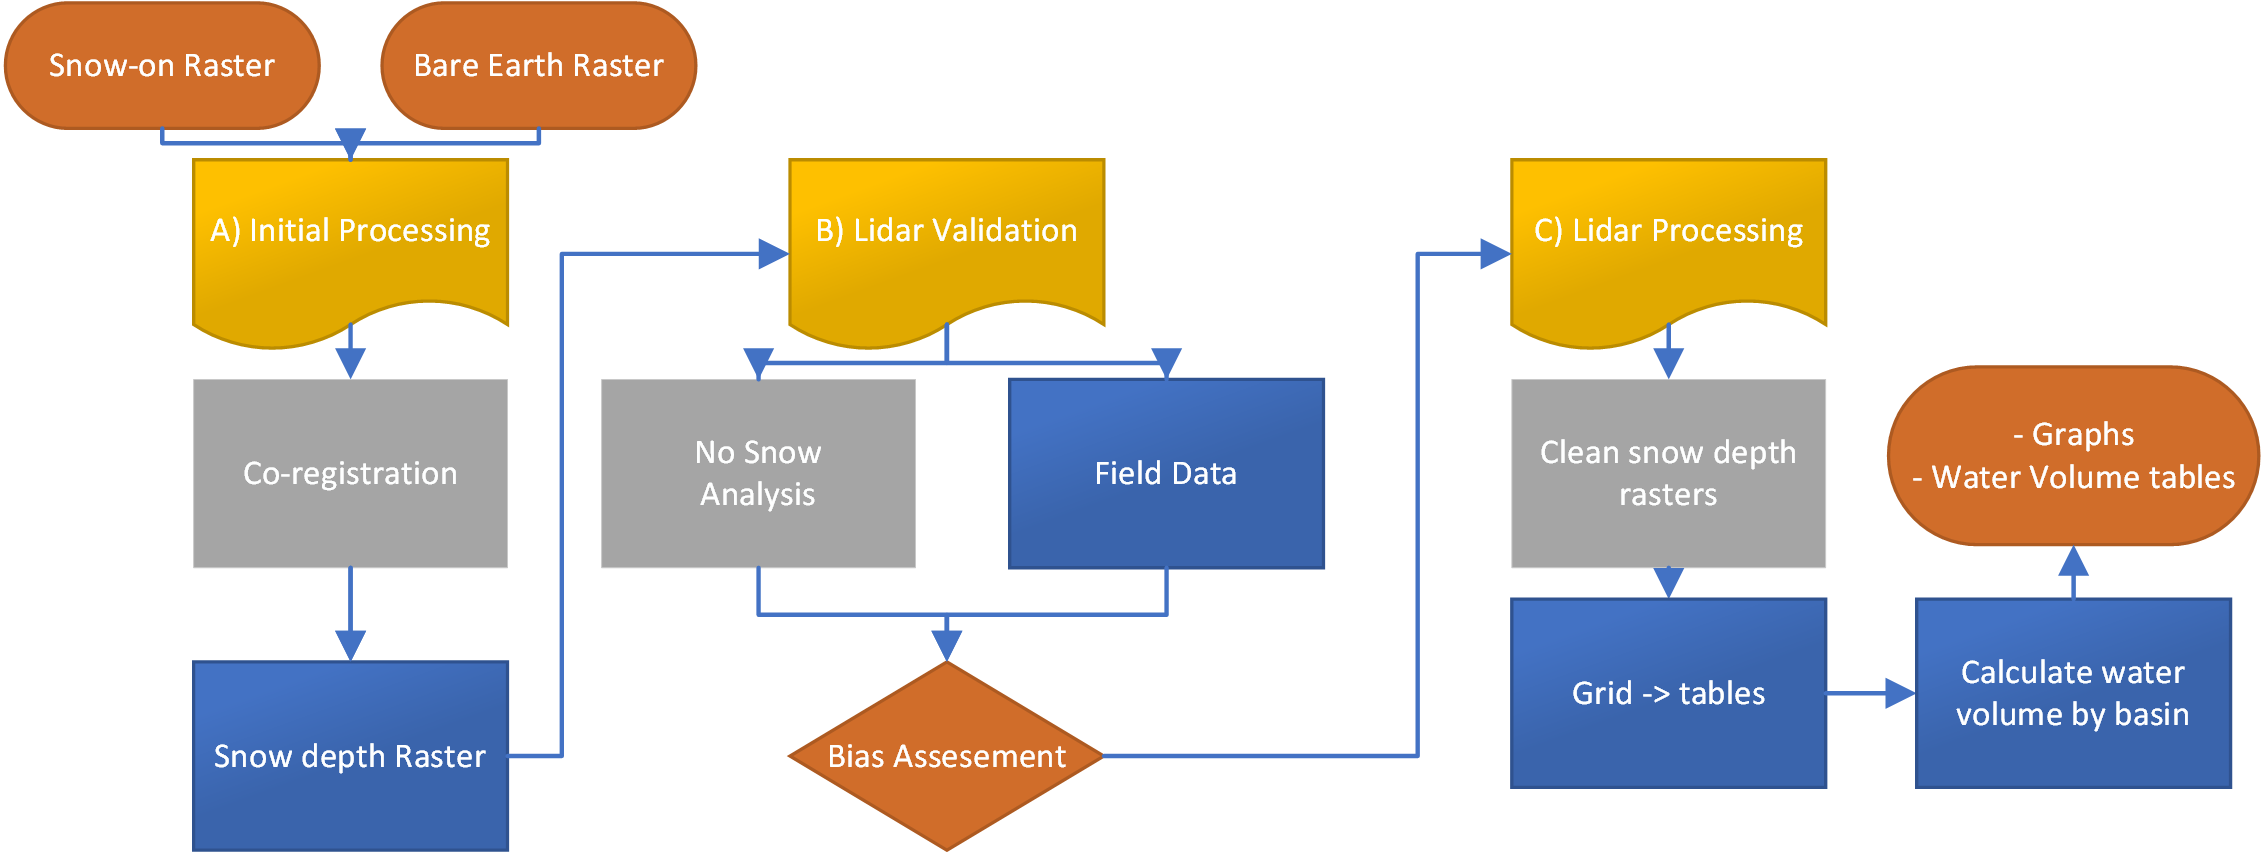

### Preliminary steps
Initial steps for the raster datasets is the snow-on datasets are co-registered to the bare earth, and an inital snowdepth grid is created. 
\
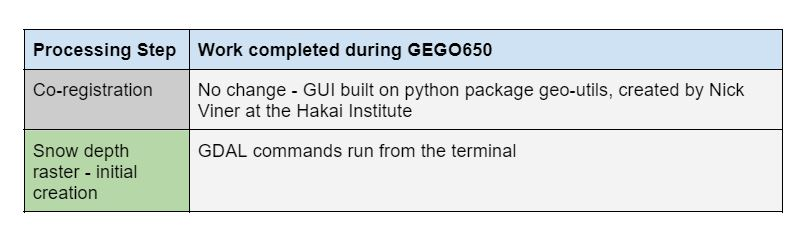









### Create Snow Depth Rasters
Script to run terminal commands to create inititial snow depth grids. The process checks whether the rasters are the same size then will proceed to either A) warp the snow depth grid and subtract the bare earth or B) proceed to subtract the bare earth from snow depth. 
#### Troubleshooting
If issues with subprocess command, this can be run directly from the terminal. The "shell = True" solved my problems as I need to activate my anaconda environment to succesfully run GDAL commands. 

In [ ]:
from osgeo import gdal
import numpy
import os
import rasterio as rio
import subprocess
import sys
from subprocess import Popen, PIPE, CalledProcessError

In [ ]:
#function to subtract the bare earth from the snow on raster to create snow depth grid
def gdal_calc(bareearth_raster, snowon_raster, gdalcalc,snowdepth_name):
    snowdepth_directory = os.path.join("outputs", snowdepth_name)
    print(snowdepth_directory)
     #if this file already exists, gdal_calc will not run 
    if os.path.exists(snowdepth_directory): 
        os.remove(snowdepth_directory)
    cmd_calc = 'python {} -A {} -B {} --outfile={} --calc="A-B"'.format(gdalcalc, snowon_raster, bareearth_raster,snowdepth_directory)
    #this will print the gdal calc processing
    with Popen(cmd_calc, stdout=PIPE, bufsize=1, universal_newlines=True) as p:
        for line in p.stdout:
            print(line, end='') # process line here
    subprocess.run(cmd_calc, shell=True) #should exit with code 0 if succesful 

In [ ]:
#function to first warp the "snowon_raster" to the bare earth if different extents
def gdal_warp(bareearth_raster, snowon_raster, be_read):
    #create the file name by adding warp to the snowon raster file name
    print("creating bounding box..")
    min_x=be_read.bounds[0]
    max_x=be_read.bounds[2]
    min_y=be_read.bounds[1]
    max_y=be_read.bounds[3]
    warp_name= str(snowon_raster)[:-4] + "_warp.tif"
    print(warp_name)
    #if this file already exists, gdawarp will not run 
    if os.path.exists(warp_name): 
        os.remove(warp_name)
    #creating command statement   
    cmd_warp = 'gdalwarp -te {} {} {} {} {} {}'.format(min_x, min_y, max_x, max_y, snowon_raster, warp_name)
    #enabling subprocess to print out live processing
    with Popen(cmd_warp, stdout=PIPE, bufsize=1, universal_newlines=True) as p:
        for line in p.stdout: 
            print(line, end='')
    #call the gdal_warp command
    subprocess.run(cmd_warp, shell=True)
    #return the output file
    return warp_name

In [ ]:
#file directrories, update as needed
bareearth_raster = r"inputs\EGM_BE_wgs84_1m.tif"
snowon_raster =  r"inputs\EGM_P01_STM_coreg.tif"
gdalcalc =  r"inputs\gdal_calc.py"

#based on snow_on raster name, may need to update if your naming convention differs
snowdepth_name = str(snowon_raster)[7:-14] + "_SD.tif"
print(snowdepth_name)

#read in the rasters
be_read = rio.open(bareearth_raster)
snowon_read = rio.open(snowon_raster)

#Check if the rasters are different sizes
if be_read.shape != snowon_read.shape:
    #Warp the snowon raster then reassign the variable
    snowon_raster = gdal_warp(bareearth_raster, snowon_raster, be_read)

#subtract the bare earth from the snow on raster and save in outputs folder
gdal_calc(bareearth_raster, snowon_raster, gdalcalc,snowdepth_name)

### Lidar validation
The Lidar Validation process is used to assess for bias within the data set. 

#### Field data processing
This script will:<br>
A) Turn a csv file into a georeferenced shapefile<br>
B) Extract information from rasters to points<br>
C) Summarize stats<br>
D) plot points

In [2]:
#define the watershed, phase, and year for plot titles
wshed = "Englishman"
phase = "1"
year = "2021"
title = "{} {} ACO Snow Survey, Phase {}".format(wshed, year, phase)

In [3]:
#read in csv
field_data = pd.read_csv("inputs/EGM_P01_21_fielddata.csv")
display(field_data.head())

,aco_flight_number,plot_datetime,study_area,plot_id,plot_type,cardinal,distance,multi_core,depth,core,plug,mass,notes,elevation,longitude,latitude,easting,northing
0,1,3/9/2021 16:36,Englishman,S3F,Cardinal 10 m,Centre,NaN,NaN,240,NaN,0,NaN,NaN,1376.939941,-124.567667,49.203733,385807.369,5451287.001
1,1,3/10/2021 10:39,Englishman,S1A,Cardinal 10 m,Centre,NaN,no,365,345.0,0,1380.0,NaN,1552.520020,-124.571406,49.209643,385548.621,5451949.644
2,1,3/10/2021 12:50,Englishman,E1A,Cardinal 10 m,Centre,NaN,NaN,415,NaN,0,NaN,NaN,1549.069946,-124.572578,49.210793,385465.967,5452079.282
3,1,3/11/2021 13:51,Englishman,N2F,Cardinal 10 m,Centre,NaN,NaN,320,NaN,0,NaN,NaN,1332.550049,-124.557102,49.199162,386566.412,5450763.019
4,1,3/11/2021 13:51,Englishman,N2F,Cardinal 10 m,Centre,NaN,no,308,290.0,0,1320.0,NaN,1332.550049,-124.557102,49.199162,386566.412,5450763.019


In [4]:
#extract the crs from the lidar dataset
with rio.open("outputs/EGM_P01_SD.tif") as lidar_sd:
    CRS = lidar_sd.meta["crs"]
#convert the pandas df to gdf
pts = gpd.GeoDataFrame(field_data, geometry=gpd.points_from_xy(field_data.easting, field_data.northing), crs=CRS)

In [7]:
#extract eastings and northings from geodata frame
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pts.index = range(len(pts))
coords = [(x,y) for x,y in zip(pts.easting, pts.northing)]

#load in raster layers and extract the data
def read_extract_raster(pts,infile, variable):
    col_name = str(variable)
    variable = rio.open(infile, masked=True)
    #identify no data value
    nodataval = variable.nodatavals
    #extract the no data value from tuple
    nodataval=nodataval[0]
    #loop through the data points and sample the raster value
    pts[col_name]=[x[0] for x in variable.sample(coords)]
    #assign 0 to no data values of CHM
    if "canopy" in col_name:
        pts[col_name] = pts[col_name].map(lambda x: 0 if x == nodataval  else x)
    else:
    #assign NaN to the no data values for else
        pts[col_name] = pts[col_name].map(lambda x: np.nan if x == nodataval  else x)
    # return the dataframe
    return pts

#run function to extract raster data 
pts = read_extract_raster(pts,"inputs/Englishman_1m_Canopy_Height_WGS84_z10.tif","canopy_height")
pts = read_extract_raster(pts, "inputs/Englishman_1m_Canopy_Density_WGS84_z10.tif", "canopy_density")
pts = read_extract_raster(pts, "inputs/Englishman_1m_Canopy_Cover_WGS84_z10.tif", "canopy_cover")
pts = read_extract_raster(pts, "inputs/EGM_aspect.tif", "aspect")
pts = read_extract_raster(pts, "inputs/EGM_BE_wgs84_1m.tif", "elevation")
pts = read_extract_raster(pts,"outputs/EGM_P01_SD.tif", "SD_lidar")
pts = read_extract_raster(pts,"inputs/EGM_slope.tif", "slope")

#format fields, create differnece in snow depth column
pts["SD_lidar"]  = round(pts["SD_lidar"]*100)
pts["field - lidar"] = pts["depth"]-pts["SD_lidar"]



def aspect(df, old_col, new_col):
    conditions_asp = [
        df[old_col] == -1,
        df[old_col] <= 22.5,
        df[old_col] <= 67.5,
        df[old_col] <= 112.5,
        df[old_col] <= 157.5,
        df[old_col] <= 202.5,
        df[old_col] <= 247.5,
        df[old_col] <= 292.5,
        df[old_col] <= 337.5,
        df[old_col] <= 360]

    values_asp = ["Flat", "North", "Northeast", "East", "Southeast", "South", "Southwest", "West", "Northwest", "North"]
    df[new_col] = np.select(conditions_asp, values_asp)

aspect(pts, "aspect", "aspect_cardinal")

def canopy_cover(df, old_col,new_col):
    conditions = [
        df[old_col] == 0,
        df[old_col] <=50, 
        df[old_col] <=100
    ]
    values = ["open", "sparse trees", "under canopy"]
    df[new_col]=np.select(conditions, values)
canopy_cover(pts, "canopy_cover", "cover_type")
display(pts.head())
#export data to csv
outfile = "{}_P0{}_lidar_data.csv".format(wshed,phase)
pts.to_csv(os.path.join("outputs", "field_data", outfile),index=False)

,aco_flight_number,plot_datetime,study_area,plot_id,plot_type,cardinal,distance,multi_core,depth,core,...,geometry,canopy_height,canopy_density,canopy_cover,aspect,SD_lidar,slope,field - lidar,aspect_cardinal,cover_type
0,1,3/9/2021 16:36,Englishman,S3F,Cardinal 10 m,Centre,NaN,NaN,240,NaN,...,POINT (385807.369 5451287.001),5,75.000,75.000,236.842,245.000,18.818,-5.000,Southwest,under canopy
1,1,3/10/2021 10:39,Englishman,S1A,Cardinal 10 m,Centre,NaN,no,365,345.000,...,POINT (385548.621 5451949.644),2,50.000,60.000,148.050,343.000,12.310,22.000,Southeast,under canopy
2,1,3/10/2021 12:50,Englishman,E1A,Cardinal 10 m,Centre,NaN,NaN,415,NaN,...,POINT (385465.967 5452079.282),0,0.000,0.000,307.078,409.000,12.186,6.000,Northwest,open
3,1,3/11/2021 13:51,Englishman,N2F,Cardinal 10 m,Centre,NaN,NaN,320,NaN,...,POINT (386566.412 5450763.019),0,0.000,0.000,314.521,302.000,8.842,18.000,Northwest,open
4,1,3/11/2021 13:51,Englishman,N2F,Cardinal 10 m,Centre,NaN,no,308,290.000,...,POINT (386566.412 5450763.019),0,0.000,0.000,314.521,302.000,8.842,6.000,Northwest,open


In [8]:
#convert gdf to df
df = pd.DataFrame(pts)

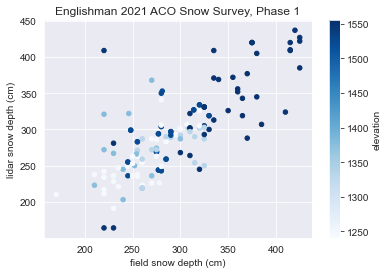

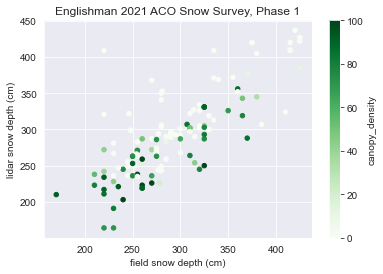

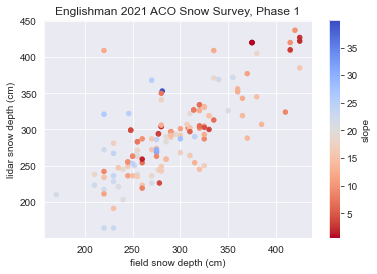

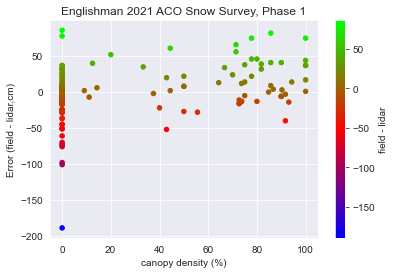

In [9]:
#generate a quick scatter plot of overall field data to summarize by raster elements
def plot_variable(df, x, y, title, color, cmap, xlabel, ylabel, outfolder):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots()
    #fig = plt.figure(facecolor=(1, 1, 1))
    df.plot(kind="scatter", x=x,y=y,c=color, cmap=cmap, ax=ax)
    ax.set(xlabel=xlabel, ylabel=ylabel,title=title)
    output = "{}_P0{}_{}_{}_{}.jpg".format(wshed,phase,x,y,color)
    graph_directory = os.path.join(outfolder,output)
    fig = ax.get_figure()
    fig.savefig(graph_directory, dpi=300)
    
#geneates individual plots, could combine into one figure here too. 
#Can mix and match variables within dataframe to generate other graphs
plot_variable(df, "depth", "SD_lidar", title, "elevation", "Blues","field snow depth (cm)","lidar snow depth (cm)",
"outputs/field_data")
plot_variable(df, "depth", "SD_lidar", title, "canopy_density", "Greens","field snow depth (cm)","lidar snow depth (cm)",
"outputs/field_data")
plot_variable(df, "depth", "SD_lidar", title, "slope", 'coolwarm_r',"field snow depth (cm)","lidar snow depth (cm)",
"outputs/field_data")
plot_variable(df, "canopy_density", "field - lidar", title, "field - lidar", "brg", "canopy density (%)","Error (field - lidar,cm)",
"outputs/field_data")

In [ ]:
#generate a summary table of results
def summary_stats(df,out_directory, wshed, phase):
    sum = df.groupby(
        "plot_id").agg({
        "depth": ["mean", "std", "count"],
        "SD_lidar": ["mean", "std"],
        "field - lidar" : "mean",
        "slope": "mean",
        "canopy_cover": "mean",
        "canopy_height": "mean",
        "elevation" : "mean",
        "aspect": ["min", "max"]
    
        }).round(2)
    display(sum)
    output = "{}_P0{}_plot_summaries.csv".format(wshed,phase)
    sum.to_csv(os.path.join(out_directory, output))

summary_stats(df, "outputs/field_data", wshed, phase)

In [ ]:
#graph the individual plots we want the y axis to be the same between phases
#graph code isn't pretty but she works!!

def field_plots_compare_graph(df,ymin,ymax,top_margin,title, outfolder):
    df = df.rename(columns={"depth" : "field", "SD_lidar" : "lidar"})
    #melt the dataframe to longform
    df=df.melt(id_vars=["plot_id", "cardinal", "distance", "cover_type"], value_vars=["field", "lidar"], var_name="depth_type", value_name="snow_depth")
    #create unique point value
    df["id"]= df["cardinal"]+df["distance"].astype(str)
    subset = df.columns.difference(['snow_depth'])
    #drop duplicate entries from subset less depth; some values have two depths that differ slightly from denisties vs probes
    df = df.sort_values("snow_depth", ascending=True).drop_duplicates(subset=subset, keep="last")
    #set up graph
    sns.set_style("darkgrid")
    sns.despine(left=True)
    #set font sizes
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 14
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    #Create facet grid
    g = sns.FacetGrid(df, col="plot_id", col_wrap=4, height = 4, aspect = .7)
    #g.set(ylim=(ymin, ymax), yticks=np.arange(500,50))
    g.set(ylim=(-50, 500), yticks=[0,50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600])
    
    #create plots and iterate over
    for col, col_name in enumerate(g.col_names):
        #print(col_name)
        ax = g.axes[col]
        filter = df[df["plot_id"] == col_name]
        groupby = filter.groupby(["depth_type"],as_index=False).snow_depth.mean()
        field_avg = groupby[groupby["depth_type"] == "field"]
        lidar_avg = groupby[groupby["depth_type"] == "lidar"]
        field_avg_pos = field_avg["snow_depth"].values[0]
        lidar_avg_pos = lidar_avg["snow_depth"].values[0]
        #print(field_avg_pos)
        #print(lidar_avg_pos)
        ax.axhline(field_avg_pos, color="#542788", ls="--", lw=1)
        ax.xaxis.grid(False)
        ax.axhline(lidar_avg_pos, color="#b35806", ls="--", lw=1)
    
    hue_order = ["field", "lidar"]
    # Field is purple, Lidar is orange
    palette = {"field" : "#542788", "lidar":"#b35806"}
    markers = {"open":"o", "sparse trees" : "d", "under canopy" : "^"}
    g = g.map_dataframe(sns.scatterplot, "id", "snow_depth", hue="depth_type", style="cover_type", markers = markers, hue_order = hue_order, palette = palette)
    g = g.set(xticklabels=[], xlabel=None)
    g.set_ylabels(size = 10, label = "Snow Depth (cm)")
    g = g.add_legend()

    #add title and adjust margins, can customize top margin value in function
    plt.suptitle(title + "\n Field Plot Validations")
    plt.subplots_adjust(hspace=0.07, wspace=0.02, top=top_margin)
    
    #set export file name and directroy
    output = "{}_P0{}_validation_plots.jpg".format(wshed,phase)
    graph_directory = os.path.join(outfolder, output)
    plt.savefig(graph_directory, dpi=300)
    
    plt.show()
    
field_plots_compare_graph(df, -50, 500,.9,title, "outputs/field_data")

## SWE analysis

In [1]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import pandas as pd
import fiona
import os
import glob
from scipy import sparse
%matplotlib inline

In [2]:
#set variables
wshed = "Englishman"
wshed_abbrev = "EGM"
phase = "P01"

#directories
basin_directory = "inputs/EGM_basins"
be_directory = "inputs/EGM_BE_wgs84_1m.tif"
aspect_directory = "inputs/EGM_Aspect.tif"
snow_depth_directory = "inputs/EGM_P01_SD_clean.tif"

In [3]:
#read in metadata for surveys
meta_df = pd.read_csv("inputs/{}_meta.csv".format(wshed_abbrev))
display(meta_df)

,wshed,phase,l_ci,multiplier,h_ci,resolution
0,EGM,P01,0.348,0.38,0.415,1
1,EGM,P02,0.400,0.42,0.432,1
2,EGM,P03,0.476,0.50,0.519,1
3,EGM,P04,0.512,0.53,0.547,1
4,EGM,P05,0.554,0.57,0.589,1


In [4]:
#calculate the low and high confidence interval multipliers
def swe_multiplier(meta_df, phase,parameter):
    parameter = meta_df.loc[meta_df['phase']== phase, parameter].item()
    return parameter

In [ ]:
#l_ci = swe_multiplier(meta_df,phase,"l_ci")
#h = swe_multiplier(meta_df,phase,"h_ci")
#multiplier = swe_multiplier(meta,phase,"multiplier")
#resolution = swe_multiplier(meta,phase,"resolution")

#display(lm)
#display(hm)
#display(multiplier)

In [5]:
#extract the cooridnates of the sub basin shapefile 
def coords (basin_directory):
    with fiona.open(basin_directory) as shapefile:
        print(shapefile)
        for feature in shapefile:
            shapes = [feature["geometry"]]
    return shapes

In [6]:
#call function to mask the 
def open_masked_raster_array(tif):
    with rio.open(tif) as src:
        #identify no data value
        nodataval = src.nodatavals
        nodataval=nodataval[0]
        print(nodataval)
        raster_image, raster_transform = rio.mask.mask(src, mask_coords, crop=True)
        raster_image = raster_image[0,:,:]
        #change the no data value to -9999.0
        raster_image[raster_image == nodataval] = -9999.0
        #unravel the array
        raster_image_unravel = np.ravel(raster_image)
        print(str(tif) + "Array length:" + str(np.shape(raster_image_unravel)))
        return raster_image_unravel

In [7]:
def aspect(df, old_col, new_col):
    conditions_asp = [
        df[old_col] == -1,
        df[old_col] <= 22.5,
        df[old_col] <= 67.5,
        df[old_col] <= 112.5,
        df[old_col] <= 157.5,
        df[old_col] <= 202.5,
        df[old_col] <= 247.5,
        df[old_col] <= 292.5,
        df[old_col] <= 337.5,
        df[old_col] <= 360]

    values_asp = ["Flat", "North", "Northeast", "East", "Southeast", "South", "Southwest", "West", "Northwest", "North"]
    df[new_col] = np.select(conditions_asp, values_asp)
    return aspect_df

In [8]:
def array_to_df(be_dem_ravel,aspect_ravel,snow_depth_ravel):
    df = pd.DataFrame({"Elev": be_dem_ravel,"Asp": aspect_ravel, "SD": snow_depth_ravel})
    print(df[df.columns[0]].count())
    print(df[df.columns[1]].count())
    print(df[df.columns[2]].count())
    #dropping any rows which have a no data value, deals with edge effects of clip basin and misaligning rasters
    df = df[(df.Elev != -9999.0) & (df.Asp != -9999.0) & (df.SD != -9999.0)]
    df = df.reset_index(drop=True)
    df['zbin'] = round(df["Elev"], -2)
    df["Asp"]= round(df["Asp"])
    print(df)
    #call function calculate aspect
    #aspect_df = aspect(df, "Asp", "Aspect")
    return array_df

In [13]:
def swe_calc(df,meta_df,phase):
    #call function to calculate swe multipliers
    l_ci = swe_multiplier(meta_df,phase,"l_ci")
    h_ci = swe_multiplier(meta_df,phase,"h_ci")
    multiplier = swe_multiplier(meta_df,phase,"multiplier")
    resolution = swe_multiplier(meta_df,phase,"resolution")
    
    df["swe"]= df["SD"]*(multiplier)
    df["swe_mm"]= df["swe"]*1000
    df["swe_lm"]=(df["SD"]*l_ci)*1000
    df["swe_hm"]=(df["SD"]*h_ci)*1000
    df["water_vol"]= df["swe"]*(resolution*resolution)
    df["lower_wv"]=df["water_vol"]*(l_ci/multiplier)
    df["upper_wv"]=df["water_vol"]*(h_ci/multiplier)
    return df
    

In [10]:
#Create dataframes for Average SWE by elevation and sum of water volume by elevation, parameter can be either zbin or aspect
def stats(parameter,basin_name,df,wshed,phase):
    avg_swe = round(df.groupby(by=[parameter],as_index=True)[["swe_mm","swe_lm", "swe_hm"]].mean(),2)
    avg_wv = round(df.groupby(by=[parameter],as_index=True)[["water_vol", "lower_wv", "upper_wv"]].sum(),2)
    merged=pd.concat([avg_swe,avg_wv],axis=1)
    merged["Phase"]= phase
    merged.to_csv("outputs/{}_{}_{}_{}.csv".format(wshed,basin_name,phase,parameter), index=True)
    return merged

In [11]:
#This will be the file loop used to iterate over the shapefiles
 
for file in os.listdir(basin_directory):
    filename = os.fsdecode(file)
    if filename.endswith(".shp"):
        #create mask coordinates from the sub-basins
        basin_name = filename[:-4]
        print(basin_name)
        basin = os.path.join(basin_directory, filename)
        mask_coords = coords(basin)
        #convert bare earth,aspect, and snow depth tiffs to raster array
        be_dem_ravel = open_masked_raster_array(be_directory)
        aspect_ravel = open_masked_raster_array(aspect_directory)
        snow_depth_ravel = open_masked_raster_array(snow_depth_directory)
        # Convert the unravelled arrays into a dataframe form
        array_df = array_to_df(be_dem_ravel,aspect_ravel,snow_depth_ravel)
        #caclulate the aspect
        aspect_df = aspect(array_df, "Asp", "Aspect"))
        #calculate the swe and water volume
        swecalc_df = swe_calc(aspect_df,meta_df,phase)
        zbin = stats("zbin", basin_name, swecalc_df,wshed,phase)
        aspect = stats("Aspect",basin_name, swecalc_df,wshed,phase)
        asp = stats("Asp", basin_name, swecalc_df,wshed,phase)
        display(aspect.head())
        

Arrowsmith
<open Collection 'inputs/EGM_basins\Arrowsmith.shp:Arrowsmith', mode 'r' at 0x2522b4ff040>
-9999.0
inputs/EGM_BE_wgs84_1m.tifArray length:(6636025,)
-9999.0
inputs/EGM_Aspect.tifArray length:(6636025,)
-3.4028234663852886e+38
inputs/EGM_P01_SD_clean.tifArray length:(6636025,)
6636025
6636025
6636025
                Elev    Asp        SD    zbin
0        1166.129028  199.0  2.097900  1200.0
1        1165.730103  195.0  2.009521  1200.0
2        1165.835083  195.0  2.144165  1200.0
3        1165.932007  188.0  2.148193  1200.0
4        1165.889038  188.0  2.236816  1200.0
...              ...    ...       ...     ...
4545914  1255.545044   68.0  1.935181  1300.0
4545915  1255.115112   75.0  1.596436  1300.0
4545916  1254.538086   79.0  1.631470  1300.0
4545917  1253.818115   81.0  1.993774  1300.0
4545918  1253.213013   84.0  2.354858  1300.0

[4545919 rows x 4 columns]


,swe_mm,swe_lm,swe_hm,water_vol,lower_wv,upper_wv,Phase
Aspect,,,,,,,
East,875.700012,801.950012,956.349976,655087.31250,599922.06250,715424.3125,P01
Flat,842.520020,771.570007,920.119995,0.84000,0.77000,0.9200,P01
North,887.929993,813.150024,969.710022,752264.62500,688916.06250,821552.1875,P01
Northeast,932.820007,854.270020,1018.739990,817281.81250,748458.18750,892557.8125,P01
Northwest,822.500000,753.239990,898.260010,487773.09375,446697.46875,532699.5625,P01


cokely
<open Collection 'inputs/EGM_basins\cokely.shp:cokely', mode 'r' at 0x2522c6d4fa0>
-9999.0
inputs/EGM_BE_wgs84_1m.tifArray length:(9705639,)
-9999.0
inputs/EGM_Aspect.tifArray length:(9705639,)
-3.4028234663852886e+38
inputs/EGM_P01_SD_clean.tifArray length:(9705639,)
9705639
9705639
9705639
                Elev    Asp        SD    zbin
0         919.841064  266.0  0.234497   900.0
1         920.141052  267.0  0.406921   900.0
2         920.440063  268.0  0.589050   900.0
3         921.055054  271.0  0.370789   900.0
4         921.491028  277.0  0.228271   900.0
...              ...    ...       ...     ...
5341460  1562.338135  324.0  3.097290  1600.0
5341461  1562.460083  316.0  3.221802  1600.0
5341462  1562.848022  305.0  3.106323  1600.0
5341463  1563.171021  301.0  3.055176  1600.0
5341464  1563.530029  298.0  2.973755  1600.0

[5341465 rows x 4 columns]


TypeError: 'DataFrame' object is not callable